# Error Estimation for Water Observations from Space <img align="right" src="../../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers), 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[DEA Waterbodies](https://www.ga.gov.au/dea/products/dea-waterbodies)

## Description

This notebook estimates uncertainties in WOfS for a single waterbody. It replicates [the WOfS classifier](https://github.com/GeoscienceAustralia/wofs/blob/master/wofs/classifier.py) with two different approaches for uncertainty estimation:

1. Monte Carlo
2. Estimated marginals of leaf nodes.

A Monte Carlo approach is when you draw random samples from a distribution to estimate some transformation of this distribution. In our case, we will add noise to Landsat images and see how this affects the WOfS predictions. A very uncertain classification will flip between wet and dry with just a little noise, whereas a more certain classification will be unchanged.

The other approach uses the structure of the decision tree to estimate probabilities (see figure below). Each leaf node in the WOfS classifier has a label (wet or dry), but different numbers of training pixels are assigned to each leaf node. We can look at the distribution of truly wet and dry pixels in each leaf node and use this as an estimate for the accuracy in that node. Then, by tracking which leaf node each pixel getting classified ends up in, we can estimate how accurate that pixel classification is.

![](../DocumentationFigures/WOfSClassifierTree.JPG "Figure 3 of Mueller et al., 2017, showing the WOfS decision tree")
Figure 3 of Mueller et al., 2017, showing the WOfS decision tree

***

## Getting started

Choose a waterbody in the "Analysis parameters" section and then run all cells.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from datacube.virtual import construct, Transformation, Measurement

sys.path.append("../../../Scripts")
from dea_plotting import rgb
from dea_spatialtools import xr_rasterize
from dea_datahandling import mostcommon_crs
from dea_waterbodies import get_waterbody

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Error-Estimation-WOfS")

### Analysis parameters

Specify the geohash for a waterbody:

In [3]:
# geohash = 'r38psere6'  # Lake Cullivel
geohash = "r0xf89fch"  # Lake Will
# geohash = 'r6ktp2tme'  # Rosendahl Reservoir
# geohash = 'r3dp1nxh8'  # Lake Burley Griffin
# geohash = 'r3f225n9h'  # Weereewa
# geohash = 'r42yzdv98'  # Lake Hart
# geohash = 'r4m0nb20w'  # Lake Menindee
# geohash = 'r4hg88vfn'  # Lake Polpitah

A product:

In [4]:
product = "ga_ls7e_ard_3"

And a date with observations:

In [5]:
date = "2001-06-03"

### Load the waterbody polygon

In [6]:
wb = get_waterbody(geohash)

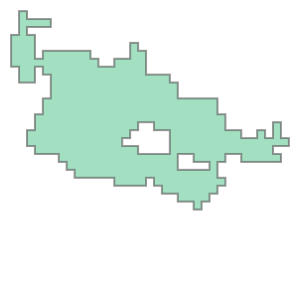

In [7]:
wb.geometry[0]

## Load a test image

We'll load a Landsat image to test out our WOfS probabilities.

In [8]:
gpg = datacube.utils.geometry.Geometry(wb.geometry[0], crs=wb.crs)

In [9]:
best_crs = mostcommon_crs(dc, product=product, query=dict(geopolygon=gpg, time=date))

In [10]:
bands = [
    "nbart_blue",
    "nbart_green",
    "nbart_red",
    "nbart_nir",
    "nbart_swir_1",
    "nbart_swir_2",
]

In [11]:
da = dc.load(
    product,
    geopolygon=datacube.utils.geometry.Geometry(wb.geometry[0].buffer(500), crs=wb.crs),
    time=date,
    output_crs=best_crs,
    resolution=(-30, 30),
    resampling="cubic",
    measurements=bands + ["fmask"],
)

In [12]:
landsat = da.isel(time=0)

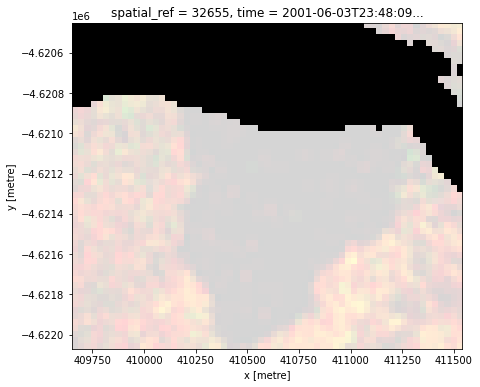

In [13]:
rgb(landsat)

## WOfS implementation

This is a functionally pure reimplementation of WOfS. This lets you do things like accelerate it with libraries that do not permit in-place modification of arrays, e.g. `jax`. This is based on the [actual implementation of WOfS](https://github.com/GeoscienceAustralia/wofs/blob/master/wofs/).

In [14]:
def band_ratio(a, b):
    """
    Calculates a normalised ratio index.
    """
    c = (a - b) / (a + b)
    return c

In [15]:
def wofs_classify(px, jnp=np):
    """Classifiy an array of Landsat pixels as wet or dry."""
    ndi_52 = band_ratio(px[4], px[1])
    ndi_43 = band_ratio(px[3], px[2])
    ndi_72 = band_ratio(px[5], px[1])

    b1 = px[0]
    b2 = px[1]
    b3 = px[2]
    b4 = px[3]
    b5 = px[4]
    b7 = px[5]

    return jnp.where(
        ndi_52 <= -0.01,
        jnp.where(
            b1 <= 2083.5,
            jnp.where(
                b7 <= 323.5,
                jnp.where(ndi_43 <= 0.61, True, False),
                jnp.where(
                    b1 <= 1400.5,
                    jnp.where(
                        ndi_72 <= -0.23,
                        jnp.where(
                            ndi_43 <= 0.22, True, jnp.where(b1 <= 473.0, True, False)
                        ),
                        jnp.where(b1 <= 379.0, True, False),
                    ),
                    jnp.where(ndi_43 <= -0.01, True, False),
                ),
            ),
            False,
        ),
        jnp.where(
            ndi_52 <= 0.23,
            jnp.where(
                b1 <= 334.5,
                jnp.where(
                    ndi_43 <= 0.54,
                    jnp.where(
                        ndi_52 <= 0.12,
                        True,
                        jnp.where(
                            b3 <= 364.5,
                            jnp.where(b1 <= 129.5, True, False),
                            jnp.where(b1 <= 300.5, True, False),
                        ),
                    ),
                    False,
                ),
                False,
            ),
            jnp.where(
                ndi_52 <= 0.34,
                jnp.where(
                    b1 <= 249.5,
                    jnp.where(
                        ndi_43 <= 0.45,
                        jnp.where(
                            b3 <= 364.5, jnp.where(b1 <= 129.5, True, False), True
                        ),
                        False,
                    ),
                    False,
                ),
                False,
            ),
        ),
    )

In [16]:
def wofs_classify_marginal(px, jnp=np):
    """Get the marginal distribution of wet or dry pixels in WOfS."""
    ndi_52 = band_ratio(px[4], px[1])
    ndi_43 = band_ratio(px[3], px[2])
    ndi_72 = band_ratio(px[5], px[1])

    b1 = px[0]
    b2 = px[1]
    b3 = px[2]
    b4 = px[3]
    b5 = px[4]
    b7 = px[5]

    return jnp.where(
        ndi_52 <= -0.01,
        jnp.where(
            b1 <= 2083.5,
            jnp.where(
                b7 <= 323.5,
                jnp.where(ndi_43 <= 0.61, 0.972, 1.000),
                jnp.where(
                    b1 <= 1400.5,
                    jnp.where(
                        ndi_72 <= -0.23,
                        jnp.where(
                            ndi_43 <= 0.22, 0.786, jnp.where(b1 <= 473.0, 0.978, 0.967)
                        ),
                        jnp.where(b1 <= 379.0, 0.831, 0.999),
                    ),
                    jnp.where(ndi_43 <= -0.01, 0.977, 0.997),
                ),
            ),
            0.999,
        ),
        jnp.where(
            ndi_52 <= 0.23,
            jnp.where(
                b1 <= 334.5,
                jnp.where(
                    ndi_43 <= 0.54,
                    jnp.where(
                        ndi_52 <= 0.12,
                        0.801,
                        jnp.where(
                            b3 <= 364.5,
                            jnp.where(b1 <= 129.5, 0.632, 0.902),
                            jnp.where(b1 <= 300.5, 0.757, 0.885),
                        ),
                    ),
                    0.974,
                ),
                0.981,
            ),
            jnp.where(
                ndi_52 <= 0.34,
                jnp.where(
                    b1 <= 249.5,
                    jnp.where(
                        ndi_43 <= 0.45,
                        jnp.where(
                            b3 <= 364.5, jnp.where(b1 <= 129.5, 0.616, 0.940), 0.584
                        ),
                        0.979,
                    ),
                    0.984,
                ),
                0.996,
            ),
        ),
    )

We also need a function that converts our Landsat DataArray into the format expected by the classifier.

In [17]:
def xr_to_cube(landsat):
    """Convert an Landsat xarray Dataset to a DataArray for WOfS."""
    return landsat[bands].to_array(dim="band")

In [18]:
landsat_cube = xr_to_cube(landsat)

## Probabilities at leaf nodes

We can call `wofs_classify_marginal` to estimate the probabilities of each pixel based on the leaf node that classified them:

/env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


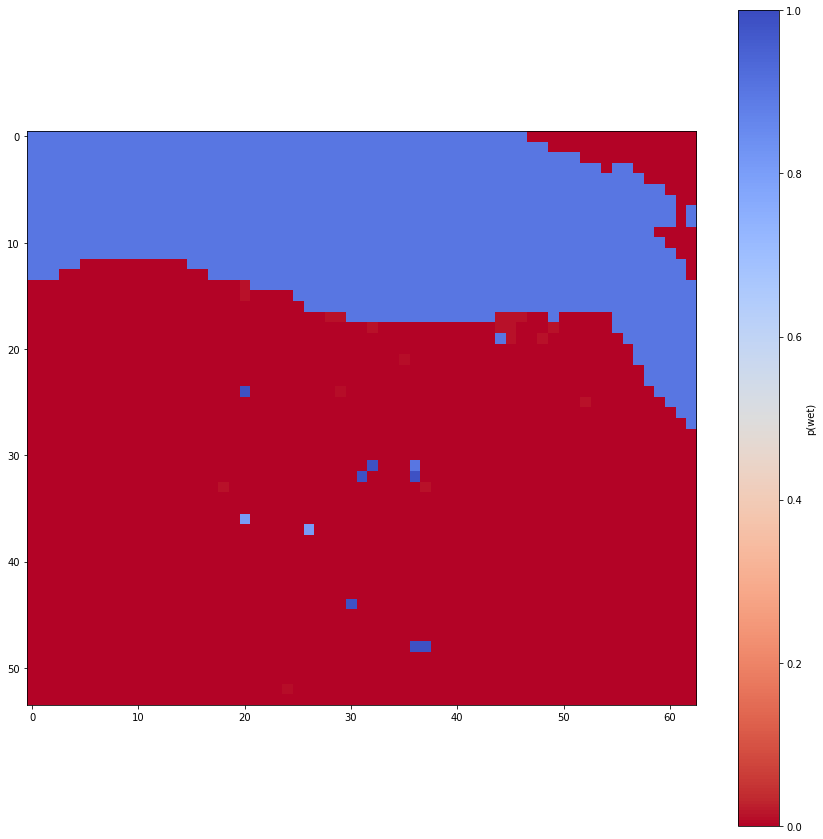

In [19]:
plt.figure(figsize=(15, 15))
plt.imshow(
    (
        wofs_classify_marginal(landsat_cube.values)
        * np.where(wofs_classify(landsat_cube.values), 1, -1)
        + 1
    )
    / 2,
    vmin=0,
    vmax=1,
    cmap="coolwarm_r",
    interpolation="nearest",
)
plt.colorbar(label="p(wet)")

## Monte Carlo sampling

Assume every pixel is a multivariate normal with a fixed amount of noise. Sample from this, then calculate WOfS.

In [20]:
def wofs_monte_carlo(ls_pixels, sigma=50, n_draws=100):
    """Generate Monte Carlo samples from WOfS assuming a given level of Gaussian noise."""
    # ls_pixels is bands x height x width
    # New axes have to go at the start for np.random.normal, but we expect bands to be the first channel, so transpose:
    sample = np.random.normal(
        ls_pixels, sigma, size=(n_draws,) + ls_pixels.shape
    ).transpose(1, 2, 3, 0)
    # Then WOfS it
    predictions = wofs_classify(sample)
    return predictions.mean(axis=-1), predictions.std(axis=-1)

In [21]:
mc = wofs_monte_carlo(landsat_cube, sigma=100)

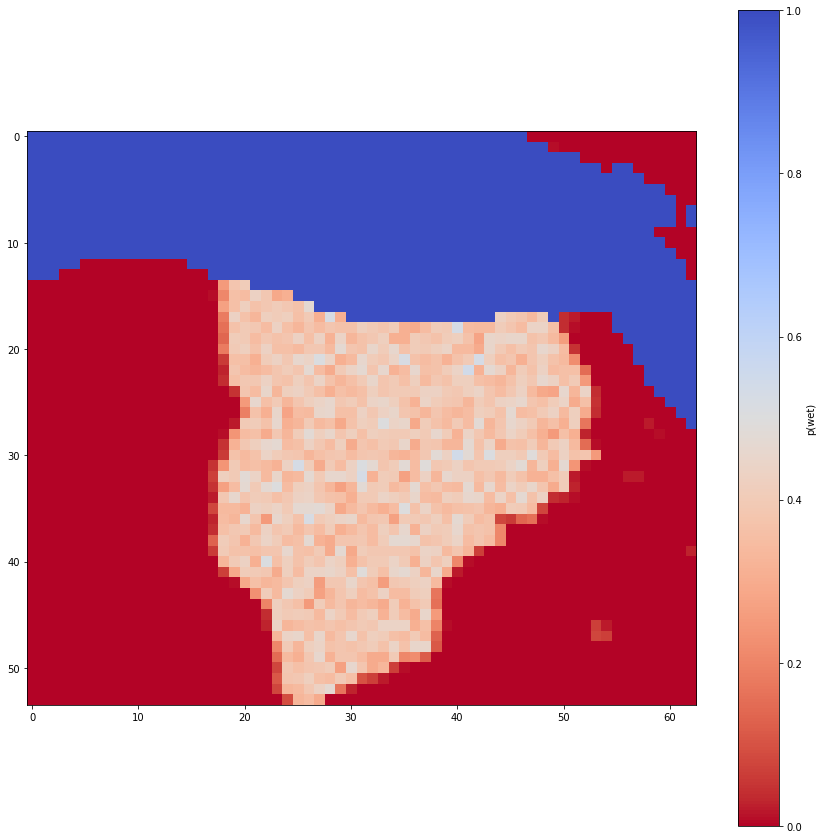

In [22]:
plt.figure(figsize=(15, 15))
plt.imshow(mc[0], cmap="coolwarm_r", vmin=0, vmax=1, interpolation="nearest")
plt.colorbar(label="p(wet)")
# plt.xlim(200, 400)
# plt.ylim(500, 300)

Compared to the leaf nodes approach, Monte Carlo does a much better job at characterising this lake as uncertain. We also get smoother outputs, whereas the leaf nodes approach has only twice as many possible probabilistic outputs as there are leaf nodes.

## Virtual product

Finally let's build a virtual product for loading the marginals. This will allow easy reuse of the method by letting us load it with a datacube-like API.

First we define the transformation:

In [23]:
WOFS_OUTPUT = [{"name": "water", "dtype": "uint8", "nodata": 1, "units": "1"}]
NO_DATA = (
    1 << 0
)  # (dec 1)   bit 0: 1=pixel masked out due to NO_DATA in NBAR source, 0=valid data in NBAR
MASKED_CLOUD = 1 << 6  # (dec 64)  bit 6: 1=pixel masked out due to cloud
MASKED_CLOUD_SHADOW = 1 << 5  # (dec 32)  bit 5: 1=pixel masked out due to cloud shadow
YES_WATER = 128


def fmask_filter(fmask):
    masking = np.zeros(fmask.shape, dtype=np.uint8)
    masking[fmask == 0] += NO_DATA
    masking[fmask == 2] += MASKED_CLOUD
    masking[fmask == 3] += MASKED_CLOUD_SHADOW

    return masking


class WOfSClassifier(Transformation):
    def __init__(self):
        self.output_measurements = {m["name"]: Measurement(**m) for m in WOFS_OUTPUT}

    def measurements(self, input_measurements):
        return self.output_measurements

    def compute(self, data):
        wofs = []
        for time_idx in range(len(data.time)):
            data_time = data.isel(time=time_idx)
            nbar_bands = data_time[bands].to_array(dim="band")
            water = xr.DataArray(
                (YES_WATER * wofs_classify(nbar_bands)) | fmask_filter(data_time.fmask),
                coords={"x": nbar_bands.coords["x"], "y": nbar_bands.coords["y"]},
                dims=["y", "x"],
            )
            probs = xr.DataArray(
                (wofs_classify_marginal(nbar_bands)),
                coords={"x": nbar_bands.coords["x"], "y": nbar_bands.coords["y"]},
                dims=["y", "x"],
            )
            ds = xr.Dataset({"water": water, "probability": probs})
            wofs.append(ds)
        wofs = xr.concat(wofs, dim="time")
        wofs.coords['time'] = data.coords['time']
        wofs.attrs["crs"] = data.attrs["crs"]
        nodata_set = np.bitwise_and(wofs.water.data, NO_DATA) == NO_DATA
        wofs.water.data[nodata_set] = np.array(NO_DATA, dtype="uint8")
        return wofs

Then we build the transformation into a virtual product:

In [24]:
wofs_product = construct(
    transform=WOfSClassifier,
    input=dict(product=product, measurements=bands + ["fmask"]),
)

Now we can `.load` anything we like. Here's the waterbody from before:

In [25]:
wofs_loaded = wofs_product.load(
    dc,
    geopolygon=datacube.utils.geometry.Geometry(wb.geometry[0].buffer(500), crs=wb.crs),
    time=date,
    output_crs=best_crs,
    resolution=(-30, 30),
    resampling="nearest",
)

In [26]:
def plot_wofs(wofs_loaded):
    xr.where(
        (wofs_loaded.water != MASKED_CLOUD) & (wofs_loaded.water != MASKED_CLOUD_SHADOW),
        wofs_loaded.probability,
        np.nan,
    ).isel(time=0).plot.imshow(interpolation='nearest')

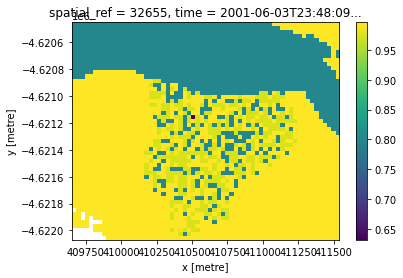

In [27]:
plot_wofs(wofs_loaded)

And here's part of Lake Gordon:

In [28]:
wb_gordon = get_waterbody('r0rvh8fpb')
wofs_gordon = wofs_product.load(
    dc,
    geopolygon=datacube.utils.geometry.Geometry(wb_gordon.geometry[0].buffer(500), crs=wb_gordon.crs),
    time='2001-12-28',
    output_crs=best_crs,
    resolution=(-30, 30),
    resampling="cubic",
)

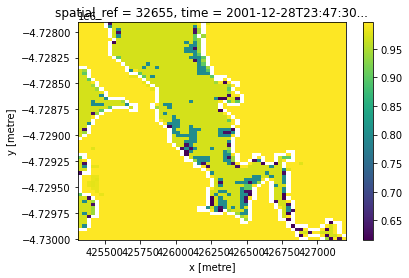

In [29]:
plot_wofs(wofs_gordon)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2020

**Compatible datacube version:** 

In [30]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)